# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

### Alejandro Somarriba Aguirre - A01751277

## Introducción

El problema a resolver con este proyecto es la identificación de cartas de jugar mediante un modelo de aprendizaje profundo hecho con una red neuronal convolutiva. En una baraja regular de cartas hay 54 cartas, divididas en 13 cartas de 4 palos diferentes, y 2 Jokers. En un contexto como algún casino, puede ser importante ser capaz de identificar las cartas que se juegan en un juego, ya que puede prevenir que haya trampa de algún tipo.<br>
El dataset que se utilizó para el modelo fue obtenido de Kaggle (https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification) son imágenes de cartas de jugar, con aproximadamente 120 imágenes por cada carta diferente.

## Datos

Los datos de Kaggle ya estaban divididos en conjuntos de entrenamiento, validación y prueba, pero debido a que en los conjuntos de validación y prueba solamente había 5 imágenes por cada carta, se decidió juntar todos los conjuntos y separarlos manualmente, ya que se consideró que sería muy pocas imágenes de validación y prueba.

Se comienza importando las librerías necesarias y obteniendo los datos desde Kaggle:

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil, pathlib
from keras.utils import image_dataset_from_directory
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/cards-image-datasetclassification
!unzip cards-image-datasetclassification.zip

%matplotlib inline

Streaming output truncated to the last 5000 lines.
  inflating: train/jack of spades/059.jpg  
  inflating: train/jack of spades/060.jpg  
  inflating: train/jack of spades/061.jpg  
  inflating: train/jack of spades/062.jpg  
  inflating: train/jack of spades/063.jpg  
  inflating: train/jack of spades/064.jpg  
  inflating: train/jack of spades/065.jpg  
  inflating: train/jack of spades/066.jpg  
  inflating: train/jack of spades/067.jpg  
  inflating: train/jack of spades/068.jpg  
  inflating: train/jack of spades/069.jpg  
  inflating: train/jack of spades/070.jpg  
  inflating: train/jack of spades/071.jpg  
  inflating: train/jack of spades/072.jpg  
  inflating: train/jack of spades/073.jpg  
  inflating: train/jack of spades/074.jpg  
  inflating: train/jack of spades/075.jpg  
  inflating: train/jack of spades/076.jpg  
  inflating: train/jack of spades/077.jpg  
  inflating: train/jack of spades/078.jpg  
  inflating: train/jack of spades/079.jpg  
  inflating: train/jack o

Para mantener transparencia, es importante mencionar que en la liga de Kaggle también se encuentran 2 modelos pre-entrenados que realizan la tarea de clasificar las imágenes. Para este proyecto, solamente se utilizan las imágenes de las cartas; en ningún momento se usan los modelo pre-entrenados.

Además de las imágenes, en los datos de Kaggle también había un archivo .csv en el que venía un desglose de los directorios de todas las imágenes, al igual que su clase y el tipo de carta que era. A continuación se lee dicho archivo en un DataFrame y se le hace una ligera limpieza para eliminar una fila sobrante y para cambiar los valores de "xxx" a "joker" en la columna "card type". Del mismo modo, se añadió otra columna en la que se indica el palo de la carta.

In [2]:
cards = pd.read_csv("cards.csv")

cards["card type"].replace("xxx", "joker", inplace=True)
cards["suit"] = cards["labels"].map(lambda x : x if x == "joker" else x[x.index("of")+3:])
cards.drop(120, inplace=True)
cards.reset_index(inplace=True, drop=True)

cards.head()

,class index,filepaths,labels,card type,data set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


Luego, para facilitar el manejo de los datos, se añadió otra columna al DataFrame, en la que se guardan las imágenes de todas las cartas.

In [3]:
img_list = []

for path in cards["filepaths"]:
  im_temp = np.array(Image.open(path))
  img_list.append(im_temp)

cards["image"] = pd.DataFrame({"image":img_list})
cards.head()

,class index,filepaths,labels,card type,data set,suit,image
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs,"[[[248, 248, 246], [251, 251, 249], [249, 249,..."
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs,"[[[0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0], ..."
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs,"[[[252, 255, 255], [252, 255, 255], [252, 252,..."
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs,"[[[254, 255, 253], [253, 255, 250], [253, 254,..."


Por si acaso, se guarda el DataFrame como un archivo .csv

In [ ]:
# cards.to_csv("cards_clean.csv", index=False)

A continuación, se muestra una carta desde el DataFrame para probar que se guardaron bien.

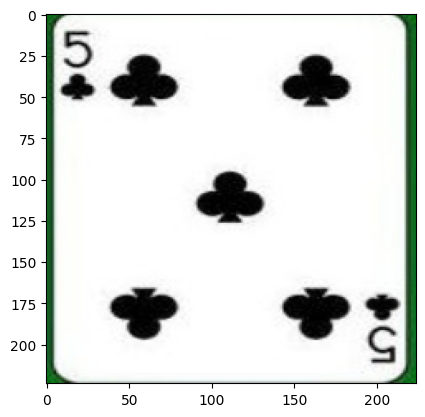

In [4]:
plt.imshow(cards["image"][1234])

Luego, se hace la separación de los datos de entrenamiento y prueba (la parte de validación se hace más adelante al ajustar el modelo). En la función <code>train_test_split</code>, se indica el parámetro <code>stratify</code> para asegurar que al dividir los datos, las clases no queden desbalanceadas. Se decidió hacer una división de 80% para entrenamiento y 20% para prueba porque se consideró que para 53 clases no se tenían muchas imágenes, por lo que se le quiere a dar más datos al entrenamiento.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(cards["image"], cards["class index"], test_size=0.2, stratify=cards["class index"])

Se puede verificar que los conjuntos no quedaron con clases desbalanceadas mostrando un histograma de las clases (hay 53 clases)

<Axes: >

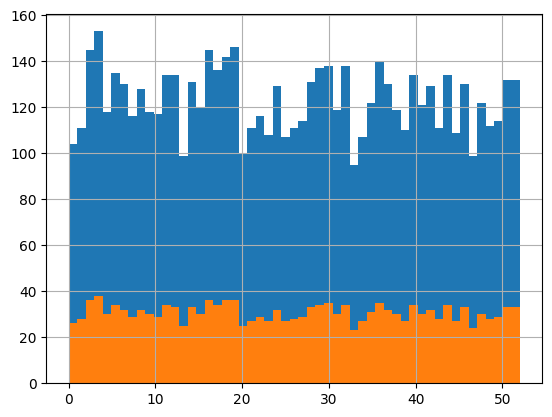

In [6]:
y_train.hist(bins=53)
y_test.hist(bins=53)

Se puede observar que están decentemente distribuidas

Debido a que la librería para el modelo utiliza arreglos de NumPy, se transforman los conjuntos de datos en arreglos de NumPy

In [7]:
X_train2 = np.array(X_train.to_list())
X_test2 = np.array(X_test.to_list())
y_train2 = np.array(y_train)
y_test2 = np.array(y_test)

## Desarrollo del modelo

A continuación se comienza a desarrollar la red neuronal, utilizando la librería de Keras.

Para el primer modelo, después de la capa de entrada, se añade una capa para escalar los datos para que tengan valores entre 0 y 1. Después, se añaden 6 capas de convolución con diferentes números de filtros seguidas de capas de pooling. Al final, se añade una capa para aplanar las imágenes en un vector unidimensional para que pueda pasar a una capa densa con 53 neuronas (1 por cada clase) con activación Softmax.

In [8]:
from keras import layers

model = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(53, activation="softmax")])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

Se utiliza la métrica de pérdida de <code>sparse_categorical_crossentropy</code> porque se trata de un problema de clasificación con varias clases. El optimizador se colocó como <code>adam</code> porque generalmente da buenos resultados. Finalmente, se incluye la métrica de <code>accuracy</code> para ver en general cuántas observaciones fueron clasificadas correctamente.

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

A continuación, se ajusta el modelo con los datos de entrenamiento. Se indica que entrene por 10 épocas y que reserve el 10% de los datos de entrenamiento para validación.

In [10]:
history = model.fit(X_train2, y_train2, epochs=10, validation_split=0.1)

Epoch 1/10
184/184 [==============================] - 23s 61ms/step - loss: 3.0975 - accuracy: 0.1855 - val_loss: 2.3540 - val_accuracy: 0.3507
Epoch 2/10
184/184 [==============================] - 9s 48ms/step - loss: 1.8086 - accuracy: 0.5017 - val_loss: 1.6076 - val_accuracy: 0.5681
Epoch 3/10
184/184 [==============================] - 9s 48ms/step - loss: 1.3016 - accuracy: 0.6424 - val_loss: 1.4290 - val_accuracy: 0.6233
Epoch 4/10
184/184 [==============================] - 9s 47ms/step - loss: 0.9511 - accuracy: 0.7351 - val_loss: 1.5539 - val_accuracy: 0.6554
Epoch 5/10
184/184 [==============================] - 9s 50ms/step - loss: 0.6719 - accuracy: 0.8087 - val_loss: 1.5136 - val_accuracy: 0.6784
Epoch 6/10
184/184 [==============================] - 9s 48ms/step - loss: 0.4409 - accuracy: 0.8792 - val_loss: 1.7655 - val_accuracy: 0.6708
Epoch 7/10
184/184 [==============================] - 9s 47ms/step - loss: 0.2944 - accuracy: 0.9244 - val_loss: 2.0788 - val_accuracy: 0.664

Una vez que se termina de entrenar el modelo, se muestran gráficas de cómo fue cambiando la pérdida y el accuracy con cada época.

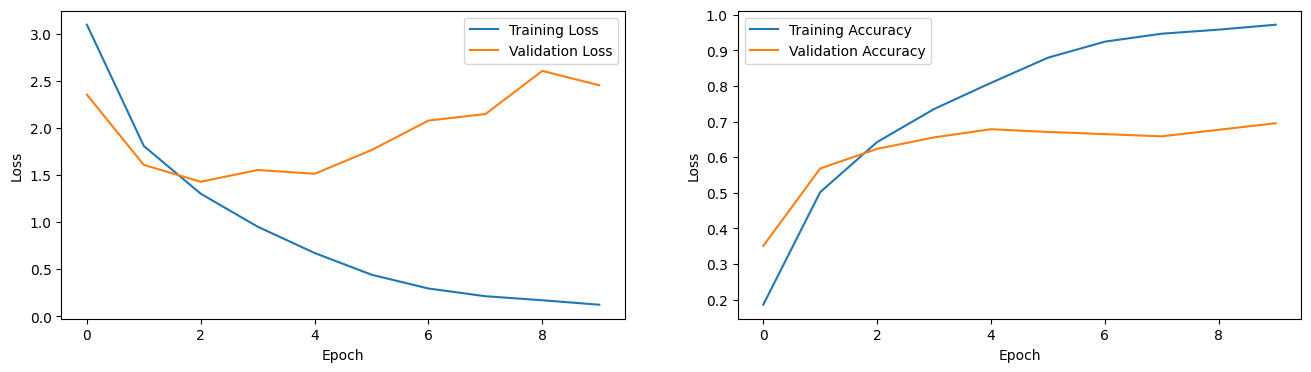

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Se puede observar que este primer modelo sufre mucho de overfitting, es decir, se aprende bastante bien los datos de entrenamiento, pero cuando es presentado con datos que no ha visto, le cuesta trabajo clasificarlos correctamente. Esto es evidente en la gráfica de la derecha, en la que se puede ver que el valor de accuracy para los datos de validación queda muy por debajo del valor de accuracy para los datos de entrenamiento.<br>
Del mismo modo, para la pérdida del modelo, observada en la gráfica de la izquierda, se puede ver que para los datos de entrenamiento llega a ser bastante baja. Sin embargo, para los datos de validación, la pérdida llega a aumentar con el tiempo.

A continuación, se evalúa el modelo con los datos de prueba.

In [18]:
loss1, accuracy1 = model.evaluate(X_test2, y_test2)
print("Loss:", loss1)
print("Accuracy:", accuracy1)

51/51 [==============================] - 1s 18ms/step - loss: 2.4367 - accuracy: 0.6671
Loss: 2.436720371246338
Accuracy: 0.6670753955841064


Parece ser que los resultados obtenidos con los datos prueba son consistentes con los datos de validación. Esto confirma que el modelo está sobreajustado a los datos de entrenamiento y que no es capaz de generalizar para imágenes que no ha visto antes.

## Ajuste del modelo

A partir de los resultados obtenidos con el primer modelo, se hacen las siguientes modificaciones para tratar de mejorar su desempeño. Dado que el modelo sufre mucho de overfitting, se tratará de utilizar la técnica de Data Augmentation, alterando ligeramente las imágenes de entrada para que tenga más imágenes con las cuales puede aprender. Se crea una capa en la que se giran las imágenes de las cartas, al igual que se les da una ligera rotación.

In [12]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomRotation(0.1)], name='data_augmentation')

Se colocan 2 de estas capas de manera consecutiva para que haya aún más datos. Adicionalmente, también se añaden capas de BatchNormalization para ver si mejora el desempeño del modelo. Al final, se añade una capa de Dropout, con una tasa de 0.1, de manera que al final de la red se apagan 10% de las neuronas, obligando al modelo a aprender de otra forma; esto debería hacer que el modelo sea más robusto.

In [13]:
model2 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          data_augmentation,
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Dropout(0.1),
                          layers.Flatten(),
                          layers.Dense(53, activation="softmax")])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                      

Nuevamente se compila el modelo con los mismos parámetros que el primero

In [14]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Sin embargo, a diferencia del primero, a este modelo se le deja correr por 25 épocas, bajo el supuesto de que ya no va a ocurrir tanto overfitting, y por lo tanto debería de poder aprender más.

In [15]:
history2 = model2.fit(X_train2, y_train2, epochs=25, validation_split=0.1)

Epoch 1/25
184/184 [==============================] - 30s 130ms/step - loss: 3.0356 - accuracy: 0.1971 - val_loss: 5.2766 - val_accuracy: 0.0322
Epoch 2/25
184/184 [==============================] - 24s 128ms/step - loss: 2.4906 - accuracy: 0.2779 - val_loss: 2.4247 - val_accuracy: 0.3124
Epoch 3/25
184/184 [==============================] - 24s 128ms/step - loss: 2.2710 - accuracy: 0.3419 - val_loss: 2.2122 - val_accuracy: 0.3369
Epoch 4/25
184/184 [==============================] - 24s 128ms/step - loss: 2.1369 - accuracy: 0.3767 - val_loss: 2.1489 - val_accuracy: 0.3997
Epoch 5/25
184/184 [==============================] - 24s 129ms/step - loss: 1.9778 - accuracy: 0.4256 - val_loss: 2.2849 - val_accuracy: 0.4012
Epoch 6/25
184/184 [==============================] - 24s 129ms/step - loss: 1.8621 - accuracy: 0.4663 - val_loss: 1.9366 - val_accuracy: 0.4992
Epoch 7/25
184/184 [==============================] - 24s 128ms/step - loss: 1.7616 - accuracy: 0.4973 - val_loss: 1.8695 - val_ac

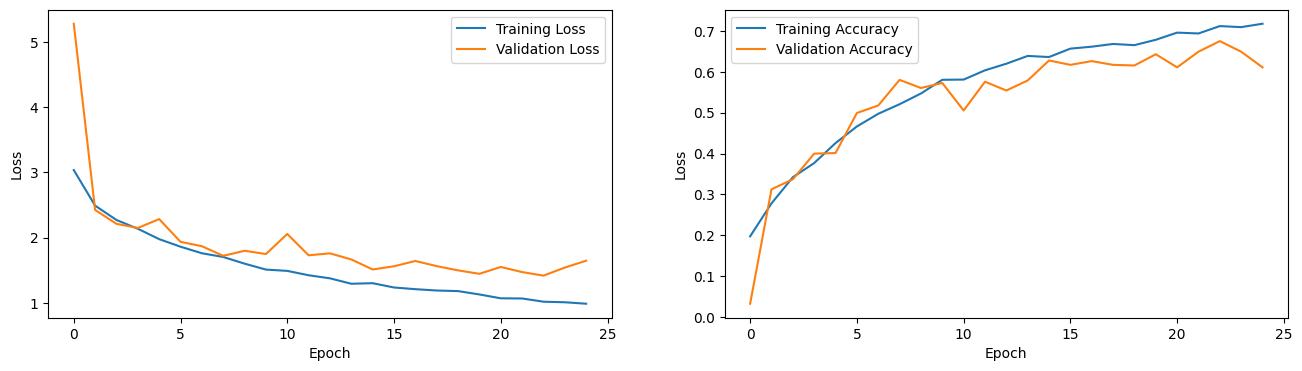

In [16]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Con este nuevo modelo, se puede observar que el grado de overfitting ha disminuido significantemente, ya que los valores de accuracy están más cercanos que en el modelo anterior (esto se visualiza en la gráfica derecha). Esto indica que los ajustes realizados al modelo tuvieron un efecto positivo en el desempeño del mismo. Desafortunadamente, a pesar de que se logró cerrar bastante la brecha entre el accuracy de los datos de entrenamiento y los datos de validación, el accuracy en general no es muy bueno. Esto podría deberse a la cantidad de clases y la cantidad de imágenes para cada clase.<br>
Por otro lado, en la gráfica izquierda se puede apreciar que el valor de pérdida para los datos de validación disminuyó considerablemente en comparación a los datos de entrenamiento. Esto indica que el modelo ha mejorado.

Igual que el modelo principal, se evalúa el modelo modificado.

In [19]:
loss2, accuracy2 = model2.evaluate(X_test2, y_test2)
print("Loss:", loss2)
print("Accuracy:", accuracy2)

51/51 [==============================] - 1s 21ms/step - loss: 1.9143 - accuracy: 0.5923
Loss: 1.9143415689468384
Accuracy: 0.5922746658325195


Parece ser que el modelo en general no es muy bueno, ya que los resultados de la evaluación con los datos de prueba son comparables a los obtenidos para el modelo sin modificar.

## Resultados

En el primer modelo, se tenía un problema muy grande de overfitting; el modelo se aprendió muy bien el conjunto de datos de entrenamiento, a tal grado que no era capaz de generalizar. Para tratar de combatir esto, se realizó un poco de Data Augmentation, se añadieron capas de BatchNormalization, se añadió una capa de Dropout y se incrementó el número de épocas que se entrenaba el modelo.
<br><br>
El nuevo modelo tuvo un mejor resultado en términos de overfitting, ya que la diferencia entre los valores de accuracy para los datos de entrenamiento y para los datos de validación disminuyó bastante. Los valores de pérdida también bajaron mucho. Todo esto parecería indicar que se obtuvo un mejor modelo. Sin embargo, a pesar de que se haya arreglado un poco el problema de overfitting, los valores de accuracy del último modelo no son muy buenos, por lo que aunque se obtuvo un mejor modelo, no es necesariamente un buen modelo.
<br><br>
No obstante, no significa necesariamente que se tenga un mal modelo, sino que podría ser simplemente que faltan imágenes para entrenar mejor al modelo. Tomando en cuenta que se está trabajando con 53 clases distintas, es bastante posible que tener menos de 200 imágenes para cada clase no es suficiente para entrenar un buen modelo. Del mismo modo, se puede considerar que para cartas de palos diferentes, pero números iguales, no hay mucha diferencia en el contenido general de la carta (un 8 de diamantes y un 8 de corazones van a tener la misma cantidad de elementos, y su única diferencia es la forma de dichos elementos).

Simplemente por probar, se predice el tipo de una carta al azar:

In [77]:
# Esto simplemente genera una lista de las clases con sus índices numéricos correspondientes
labels = [(idc, cards[cards["class index"] == idc]["labels"].head(1).values[0]) for idc in range(53)]

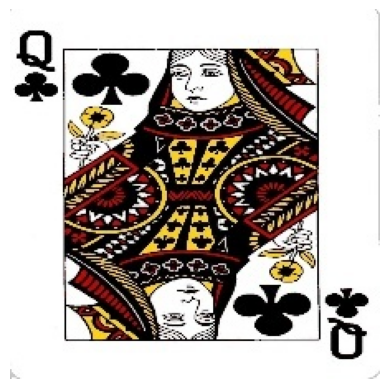

In [78]:
random_inx = np.random.choice(X_test2.shape[0])
test_image = X_test2[random_inx]

plt.axis('off')
plt.imshow(test_image)
plt.show()

In [79]:
pred = model2.predict(test_image[np.newaxis,...])
print("Model: ", labels[np.argmax(pred)])

1/1 [==============================] - 0s 19ms/step
Model:  (29, 'queen of clubs')


Después de haber corrido las 2 celdas anteriores un par de veces, parece ser que el modelo tiene más problemas con cartas que están muy estilizadas, porque para cartas que se ven "normales", no aparenta haber mucho problema.

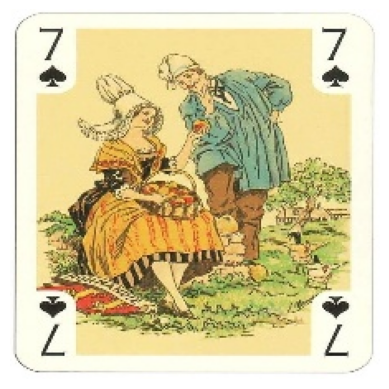

In [75]:
random_inx = np.random.choice(X_test2.shape[0])
test_image = X_test2[random_inx]

plt.axis('off')
plt.imshow(test_image)
plt.show()

In [76]:
pred = model2.predict(test_image[np.newaxis,...])
print("Model: ", labels[np.argmax(pred)])

1/1 [==============================] - 0s 19ms/step
Model:  (22, 'king of diamonds')


La carta anterior es un muy bueno ejemplo de cómo se puede confundir el modelo; la carta es un 7 de espadas, pero tiene una ilustración con personas. Dado que generalmente las únicas cartas con ilustraciones con personas son las de los reyes, reinas y jotas, es probable que el modelo haya aprendido esta característica y por eso ahora confunde la carta con un rey de diamantes.

## Reflexiones

Si se volviera a realizar el proyecto, lo primero que haría sería tratar de conseguir más imágenes para cada una de las clases. Algo que podría hacer sería cambiar un poco la orientación del problema; en el problema original se tienen 53 clases diferentes, una por cada carta de una baraja normal. Sin embargo, se puede reducir a un problema de 14 clases (una por cada número de las cartas más los Jokers) o incluso de 5 clases (una por cada palo de la baraja más el Joker). Si se reduce la cantidad de clases, pero la cantidad de imágenes se mantiene igual, entonces aumenta la cantidad de observaciones para cada clase, lo que podría ayudar a entrenar un mejor modelo.<br><br>
Alternativamente, se podría explorar el problema de otra manera; en vez de tener una salida con 53 clases, se podría hacer una clasificación con 2 salidas, una para el número de la carta (14 clases) y otra para el palo de la carta (5 clases). Esto haría el problema más interesante, pero al mismo tiempo puede que sea más complejo.<br><br>
De haber tenido más tiempo y más recursos computacionales, hubiera aumentado el número de épocas que se entrenaba el segundo modelo, ya que según la gráfica de accuracy, parecía que todavía podría seguir aprendiendo un poco más. Por otra parte, podría ser buena idea obtener imágenes de mayor resolución; alentaría más el proceso de aprendizaje, pero la calidad mejorada de las imágenes podría ayudar a que el modelo aprenda mejor las formas de cada uno de los palos, y por lo tanto podría hacer que los clasifique mejor.<br><br>
Tomando en cuenta lo observado al predecir cartas al azar en la sección de Resultados, se me ocurre que tal vez no sería una mala idea utilizar imágenes de cartas de barajas más estandarizadas, y no tanto de cartas estilizadas; esto haría que el modelo sea capaz de aprender a distinguir mejor las cartas normales, pero tendría la desventaja de que no podría clasificar cartas con estilos diferentes.

## Conclusiones

(Se mantiene pendiente a la retroalimentación antes de colocar las conclusiones...)